C:\Users\nirob\AppData\Local\Temp\ipykernel_4660\1048294035.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


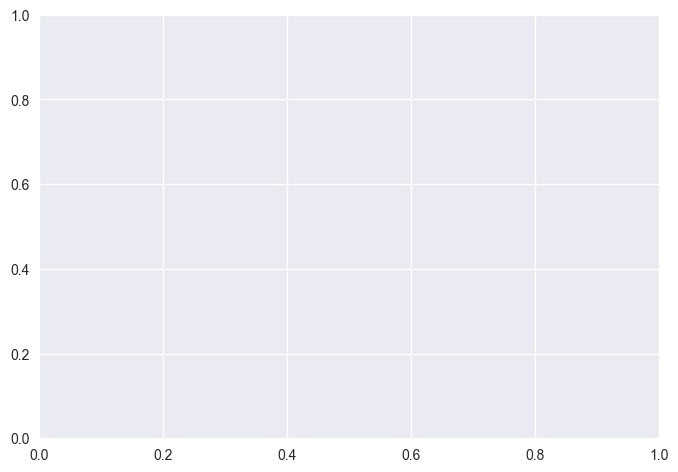

In [1]:
import os
import random
from IPython.display import HTML
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential
from keras.layers import *
import matplotlib.pyplot as plt
from keras.utils import plot_model
plt.style.use("seaborn")
ax= plt.subplot()
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping

In [2]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
CLASSES_LIST = ["Non Violence", "Violence"]
video_dir="Our_Dataset/"

def frame_extraction(video_path):
    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    skip_frames_window = max(int(video_frame_count / SEQUENCE_LENGTH), 1)
    frame_list = []
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, skip_frames_window * frame_counter)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frame_list.append(normalized_frame)

    video_reader.release()
    return frame_list

def create_dataset():
    features = []
    labels = []
    video_file_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print("Extracing data of class:", class_name)
        files_list = os.listdir(os.path.join(video_dir, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(video_dir, class_name, file_name)
            frames = frame_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.asarray(labels)
    return features, labels, video_file_paths

if __name__=="__main__":
    print("Feature extracting...")
    features,labels,video_file_paths=create_dataset()
    np.save("Features/features_Own.npy", features)
    np.save("Features/labels_Own.npy", labels)
    np.save("Features/video_file_paths_Own.npy", video_file_paths)
    print("Saved feature files successfully")
    

Feature extracting...
Extracing data of class: Non Violence
Extracing data of class: Violence
Saved feature files successfully


In [3]:
features,labels=np.load("Features/features_Own.npy"),np.load("Features/labels_Own.npy")

In [4]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2,
                                                                            shuffle=True, random_state=42)

In [5]:
print(features_train.shape,labels_train.shape)
print(features_test.shape,labels_test.shape)

(899, 16, 64, 64, 3) (899, 2)
(100, 16, 64, 64, 3) (100, 2)


In [6]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False


In [7]:
def create_model():
 
    model = Sequential()

    ########################################################################################################################
    
    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    model.summary()
    
    return model

In [8]:
Own_dataset_mobi_Lstm=create_model()
plot_model(Own_dataset_mobi_Lstm, to_file="lstm_model.png",show_shapes=True,show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [10]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
# Compiling the model 
Own_dataset_mobi_Lstm.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"]) 
 
# Fitting the model 
MobBiLSTM_model_history = Own_dataset_mobi_Lstm.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
90/90 [==============================] - 73s 697ms/step - loss: 0.6994 - accuracy: 0.5132 - val_loss: 0.6944 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/50
90/90 [==============================] - 59s 653ms/step - loss: 0.6902 - accuracy: 0.5063 - val_loss: 0.6923 - val_accuracy: 0.5278 - lr: 0.0100
Epoch 3/50
90/90 [==============================] - 58s 650ms/step - loss: 0.6911 - accuracy: 0.5466 - val_loss: 0.6884 - val_accuracy: 0.5222 - lr: 0.0100
Epoch 4/50
90/90 [==============================] - 59s 652ms/step - loss: 0.6818 - accuracy: 0.5591 - val_loss: 0.6783 - val_accuracy: 0.6111 - lr: 0.0100
Epoch 5/50
90/90 [==============================] - 57s 639ms/step - loss: 0.6610 - accuracy: 0.6300 - val_loss: 0.6398 - val_accuracy: 0.7111 - lr: 0.0100
Epoch 6/50
90/90 [==============================] - 57s 629ms/step - loss: 0.6139 - accuracy: 0.6968 - val_loss: 0.5530 - val_accuracy: 0.7778 - lr: 0.0100
Epoch 7/50
90/90 [==============================] - 56s 628ms/st

In [11]:
model_evaluation_history = Own_dataset_mobi_Lstm.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 581ms/step - loss: 0.1806 - accuracy: 0.9500


In [12]:
labels_predict = Own_dataset_mobi_Lstm.predict(features_test)

4/4 [==============================] - 5s 566ms/step


In [13]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [14]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.95


In [15]:
Own_dataset_mobi_Lstm.save('Own_dataset_mobi_Lstm.h5')

c:\Users\nirob\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 3s 663ms/step


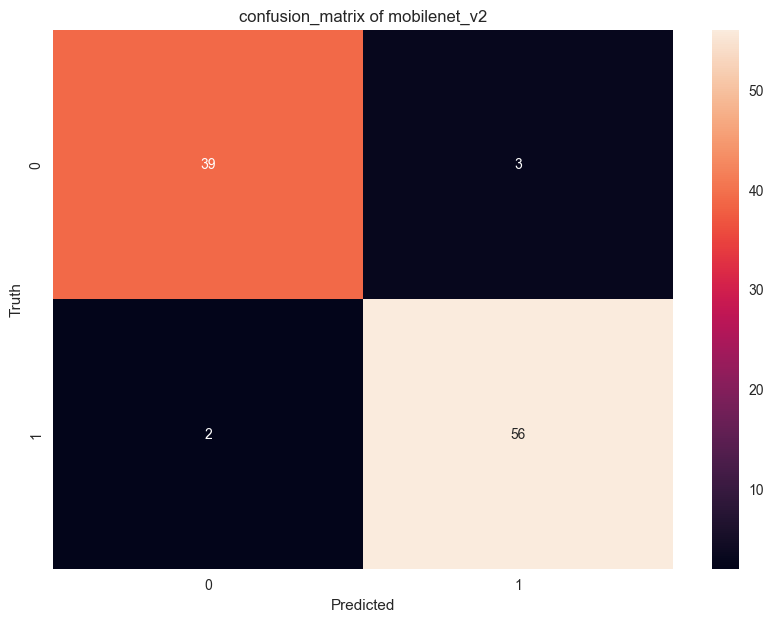


Classification Report of mobilenet_v2:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.95      0.97      0.96        58

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



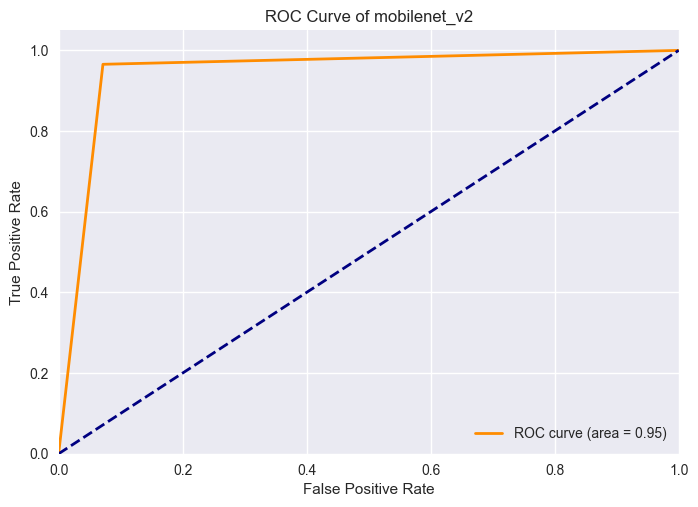

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import seaborn as sns

# Assuming `predicted_labels` are the predictions of your model on the test set
predicted_labels = Own_dataset_mobi_Lstm.predict(features_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(labels_test, axis=1)
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("confusion_matrix of mobilenet_v2")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Classification Report
print("\nClassification Report of mobilenet_v2:")
print(classification_report(true_labels, predicted_labels))

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of mobilenet_v2')
plt.legend(loc="lower right")
plt.show()


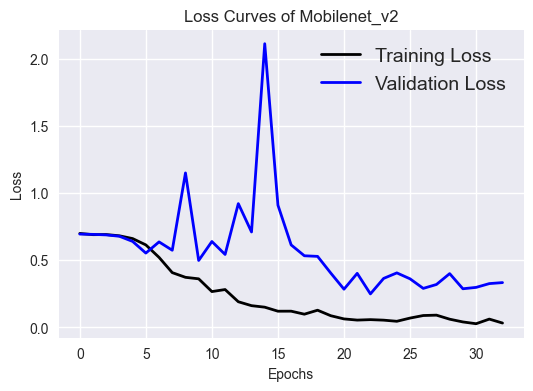

In [22]:
# Assuming `MobBiLSTM_model_history` is the returned object from your model's fit method
history = MobBiLSTM_model_history

# Plotting the loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves of Mobilenet_v2', fontsize=12)
plt.show()